In [1]:
# import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from process_movella import load_movella, detrend
from scipy.integrate import cumulative_simpson as integrate

In [2]:
IN_DIR = Path("uploads/20250703_160418")
OUT_DIR = Path("out")

if not OUT_DIR.exists():
    OUT_DIR.mkdir()

481


Text(0.5, 0.92, 'Hoop Path')

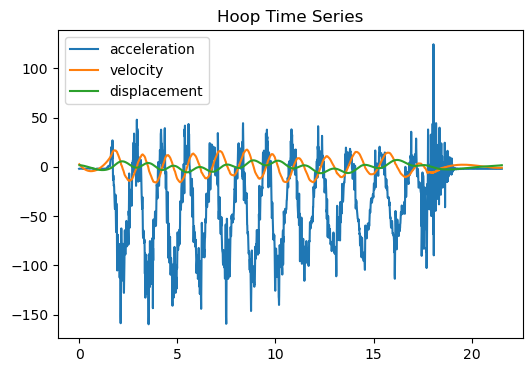

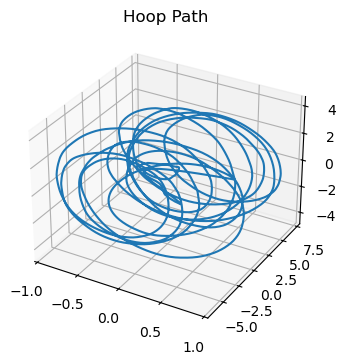

In [ ]:
# xyz: left side of hoop
# 285: right side of hoop
# 46E: on hip, above hoop (on waist belt)
# 3C4: on hip, below hoop (in pocket)
hoop_file = list(IN_DIR.glob("xyz*.csv"))[2]
hoop_data = load_movella(hoop_file, lead_time=4)
time, accel_x, accel_y, accel_z = hoop_data.T

veloc_x = detrend(time[1:], integrate(y=accel_x,x=time))
veloc_y = detrend(time[1:], integrate(y=accel_y,x=time))
veloc_z = detrend(time[1:], integrate(y=accel_z,x=time))

displ_x = detrend(time[2:], integrate(y=veloc_x,x=time[1:]))
displ_y = detrend(time[2:], integrate(y=veloc_y,x=time[1:]))
displ_z = detrend(time[2:], integrate(y=veloc_z,x=time[1:]))

fig_ts, ax_ts = plt.subplots(figsize=(6,4))
ax_ts.plot(time,accel_z,label='acceleration')
ax_ts.plot(time[1:],veloc_z,label='velocity')
ax_ts.plot(time[2:],displ_z,label='displacement')
ax_ts.legend()
ax_ts.set_title('Hoop Time Series')

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(projection='3d')
ax.plot(displ_y,displ_z,displ_x)
ax.set_title('Hoop Path')